# MixedML on Python

Linear Mixed Effect: $$Y_{ij} = \beta_0 + \beta_i X_{ij} + b_{0j} + b_{ij} X_{ij} + \epsilon_{i}$$ 
=> MixedML: $$Y_{ij} = ML(X_{ij}) + b_{0j} + b_{ij} X_{ij} + \epsilon_{i}$$


with ML: any type of Machine Learning model


LCMM is used for the (pure) random effect model:


```R
random_hlme <- hlme(
  e_fixed ~ 1,
  random = ~  1 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8,
  idiag = TRUE,
  data = data,
  subject = 'individus',
  var.time = 'temps'
)
```

Algorithm initialization:  $Y_{fixed} = Y$  

Until convergence of $squared\_residuals$:  
|  
|$~~~~~ML.fit(X, Y_{fixed})$  
|$~~~~~Y_{rand} = Y - ML(X)$  
|  
|$~~~~~HLME.fit(X, Y_{rand})$  
|$~~~~~Y_{fixed} = Y - HLME(X)$  
|    
|$~~~~~Y_{pred} = ML(X) + HLME(X)$    
|$~~~~~squared\_residuals = (Y - Y_{pred})^2$  

In [1]:
from sys import path
from pathlib import Path


def add_path(p: str):
    pth = Path(p).resolve().as_posix()
    print(pth)
    path.append(pth)


add_path("../")
add_path("../../")

/home/francois/Documents/SISTM/subSISTM/models/mixedML
/home/francois/Documents/SISTM/subSISTM/models


In [2]:
import pickle
import seaborn as sns
from matplotlib.pyplot import subplots
from pandas import DataFrame
import pandas as pd
from reservoirpy import verbosity
from reservoirpy.nodes import Reservoir, Ridge
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler

from reservoirs_synthetic_bph.utils.reservoirs import ReservoirEnsemble
from reservoirs_synthetic_bph.utils.data import get_dataframe, prepare_data
from reservoirs_synthetic_bph.utils.global_config import N_WARMUPS
from mixed_ml import MixedMLEstimator

pd.options.display.float_format = "{:.3g}".format
verbosity(0)

Added to sys.path: /home/francois/Documents/SISTM/subSISTM/models


0

In [3]:
data = get_dataframe("../../../data/synthetic_bph_1/01_test.csv")
SERIES = "individus"
TSTEPS = "temps"
#
data_train = data[data[SERIES] > 10]
data_test = data[data[SERIES] <= 10]

## Building the model 

Standard models can be used:

In [4]:
model_mlp = MLPRegressor((20, 10, 5), learning_rate="adaptive", max_iter=1000)
mixed_ml_mlp = MixedMLEstimator(model_mlp, recurrent_model=False)

Also recurrent ones:

In [5]:
model_rpy = ReservoirEnsemble(reservoir_kwargs={"units": 50},
                              ridge_kwargs={"ridge": 1e-1})
mixed_ml_rpy = MixedMLEstimator(model_rpy, recurrent_model=True)

## Training  
with all the features: $x_1,…, x_8$

In [6]:
X_LABELS = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]
Y_LABEL = "y_mixed_obs"
Y_LABELS_PRED = ["y_mixed", "y_mixed_obs"]

scaler_x = RobustScaler()
scaler_y = RobustScaler()

data_train_scaled = data_train[[SERIES, TSTEPS]].copy()
data_train_scaled[X_LABELS] = scaler_x.fit_transform(data_train[X_LABELS])
data_train_scaled[[Y_LABEL]] = scaler_y.fit_transform(data_train[[Y_LABEL]])

data_test_scaled = data_test[[SERIES, TSTEPS]].copy()
data_test_scaled[X_LABELS] = scaler_x.transform(data_test[X_LABELS])
data_test_scaled[[Y_LABEL]] = scaler_y.transform(data_test[[Y_LABEL]])

In [7]:
try:
    cvg_mlp = pickle.load(open("cvc_mlp", "rb"))
    mixed_ml_mlp = pickle.load(open("mixed_ml_mlp", "rb"))
except:
    cvg_mlp = mixed_ml_mlp.fit(data_train_scaled,
                               n_iter_improve=2,
                               min_rltv_imprv=0.01)
    pickle.dump(cvg_mlp, open("cvc_mlp", "wb"))
    pickle.dump(mixed_ml_mlp, open("mixed_ml_mlp", "wb"))

In [9]:
try:
    cvg_rpy = pickle.load("cvg_rpy", open("cvg_rpy", "rb"))
    mixed_ml_rpy = pickle.load("mixed_ml_rpy", open("mixed_ml_rpy", "rb"))
except:
    cvg_rpy = mixed_ml_rpy.fit(
        data_train_scaled,
        n_iter_improve=2,
        min_rltv_imprv=0.01,
        warmup=N_WARMUPS,
    )
    pickle.dump(cvg_rpy, open("cvg_rpy", "wb"))
    pickle.dump(mixed_ml_rpy, open("mixed_ml_rpy", "wb"))

mixedML step #00: 1.081790e-02 (best)
mixedML step #01: 6.208017e-03 (best)
mixedML step #02: 4.693796e-03 (best)
mixedML step #03: 3.928645e-03 (best)
mixedML step #04: 3.584968e-03 (best)
mixedML step #05: 3.341264e-03 (best)
mixedML step #06: 3.214180e-03 (best)
mixedML step #07: 3.143727e-03 (best)
mixedML step #08: 3.069330e-03 (best)
mixedML step #09: 3.022843e-03 (best)
mixedML step #10: 3.008287e-03
mixedML step #11: 2.983743e-03 (best)
mixedML step #12: 2.954094e-03
mixedML step #13: 2.948712e-03 (best)
mixedML step #14: 2.927903e-03
mixedML step #15: 2.920320e-03
mixedML step #16: 2.908436e-03 (best)
mixedML step #17: 2.898737e-03
mixedML step #18: 2.891869e-03
mixedML step #19: 2.886043e-03


In [10]:
def plot_convergence(cvg_mlp, cvg_rpy):
    fig, ax = subplots()
    ax.plot(cvg_mlp, label="MLP")
    ax.plot(cvg_rpy, label="Reservoir")
    ax.legend(loc="center right", fontsize="x-large")
    ax.set_yscale("log")
    ax.set_title("Convergence")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Model residuals (on scaled values)")
    _ = 0

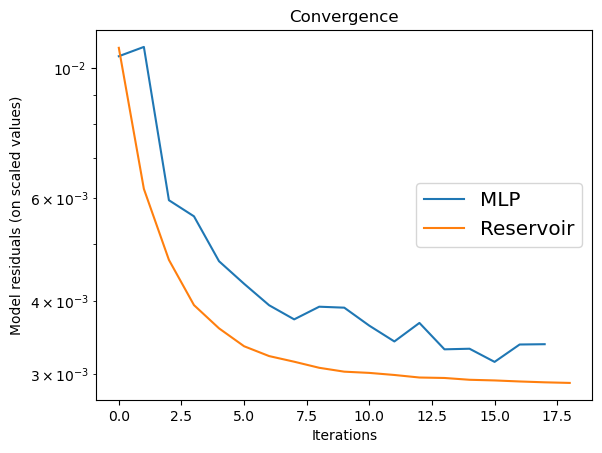

In [11]:
plot_convergence(cvg_mlp, cvg_rpy)

## Predictions

In [14]:
def get_metrics(mixed_ml_mlp, mixed_ml_rpy, data, data_scaled):
    lres = []
    for name, model in {
            "MLP": mixed_ml_mlp,
            "Reservoir": mixed_ml_rpy
    }.items():
        for subspec in [True, False]:
            for tgt_name in Y_LABELS_PRED:
                y_pred_scaled = model.predict(data_scaled,
                                              use_subject_specific=subspec)
                y_pred_scaled = y_pred_scaled.reshape((len(y_pred_scaled), 1))
                y_pred = scaler_y.inverse_transform(y_pred_scaled)

                y_tgt_wup = remove_warmup_1D(data[tgt_name], N_WARMUPS)
                y_pred_wup = remove_warmup_1D(y_pred, N_WARMUPS)
                lres.append({
                    "model": name,
                    "ss": subspec,
                    "tgt_name": tgt_name,
                    "mae": mae(y_tgt_wup, y_pred_wup),
                    "mse": mse(y_tgt_wup, y_pred_wup),
                })
    return DataFrame(lres)

### Predictions on train set

In [15]:
get_metrics(mixed_ml_mlp, mixed_ml_rpy, data_train, data_train_scaled)

NameError: name 'remove_warmup_1D' is not defined

### Predictions on test set

In [ ]:
get_metrics(mixed_ml_mlp, mixed_ml_rpy, data_test, data_test_scaled)